In [2]:
#Importing libraries needed for reading .nii files

import nibabel as nib
import numpy as np

from zipfile import ZipFile

import glob
import gzip
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [2]:
#Unzip zipped folder of original dataset

if False:
  with ZipFile('./drive/MyDrive/3D_images/hecktor_nii_cropped.zip', 'r') as f:
    f.extractall('./drive/MyDrive/3D_images')

In [3]:
#Preparing CT images and labels into desired folders
#This stage consists of unzipping and deviding inputs and targets to corresponding folders

if False:
  x = glob.glob('./drive/MyDrive/3D_images/hecktor_nii_cropped/*/', recursive = True)
  for item in x:
    y = glob.glob(item+'*', recursive = True)
    y.sort()
    s = y[0].split('/')[-1]
    with gzip.open(y[0], 'rb') as file_in:
      with open('./drive/MyDrive/3D_images/Input_images/'+s[:-3], 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)
    s = y[1].split('/')[-1]
    with gzip.open(y[0], 'rb') as file_in:
      with open('./drive/MyDrive/3D_images/Target_labels/'+s[:-3], 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)

In [4]:
x = glob.glob('./drive/MyDrive/3D_images/Input_images/*', recursive = True)
x.sort()
y = glob.glob('./drive/MyDrive/3D_images/Target_labels/*', recursive = True)
y.sort()

In [5]:
## Loading dataset to RAM and splitting to train/val/test sets
## by setting seed, we guarantee reproducability of splitting

seed = 42
indices = list(range(len(x)))
np.random.seed(seed=seed)
np.random.shuffle(indices)

train_indices = indices[60:]
val_indices = indices[30:60]
test_indices = indices[:30]

In [6]:
test_input = np.zeros(shape=(30,64,64,64), dtype='float64')
val_input = np.zeros(shape=(30,64,64,64), dtype='float64')
train_input = np.zeros(shape=(141,64,64,64), dtype='float64')

test_target = np.zeros(shape=(30,64,64,64), dtype='float64')
val_target = np.zeros(shape=(30,64,64,64), dtype='float64')
train_target = np.zeros(shape=(141,64,64,64), dtype='float64')

for i in range(30):
  test_input[i] = nib.load(x[test_indices[i]]).get_fdata()
  test_target[i] = nib.load(y[test_indices[i]]).get_fdata()

for i in range(30):
  val_input[i] = nib.load(x[test_indices[i]]).get_fdata()
  val_target[i] = nib.load(y[test_indices[i]]).get_fdata()

for i in range(141):
  train_input[i] = nib.load(x[train_indices[i]]).get_fdata()
  train_target[i] = nib.load(y[train_indices[i]]).get_fdata()

test_input = np.expand_dims(test_input, axis=-1)
val_input = np.expand_dims(val_input, axis=-1)
train_input = np.expand_dims(train_input, axis=-1)

test_target = np.expand_dims(test_target, axis=-1)
val_target = np.expand_dims(val_target, axis=-1)
train_target = np.expand_dims(train_target, axis=-1)

In [7]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)
    return 1-dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return 0.5 * (bce(y_true, y_pred) + dice_coefficient(y_true, y_pred))

In [8]:
def squeeze_excite_block(inputs, ratio=16):
  channels = inputs.shape[-1]  # Get the number of input channels
  se = layers.GlobalAveragePooling3D()(inputs)  # Apply global average pooling
  se = layers.Dense(channels // ratio, activation='relu')(se)  # Squeeze operation
  se = layers.Dense(channels, activation='sigmoid')(se)  # Excitation operation
  se = layers.Reshape((1, 1, channels))(se)  # Reshape to match input shape
  scaled_inputs = layers.Multiply()([inputs, se])  # Scale the input features
  return scaled_inputs

def conv_block(inputs , filters):
  x = layers.Conv3D(filters=filters, kernel_size=3, activation='elu', padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Conv3D(filters=filters, kernel_size=3, activation='elu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = squeeze_excite_block(x)  # Apply the SE block
  return x

In [9]:
## Forward Model architecture

# Contracting Path (Encoder)
forward_inputs = layers.Input(shape=(64, 64, 64, 1))
conv1 = conv_block(forward_inputs, 32)
pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = conv_block(pool1, 64)
pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = conv_block(pool2, 128)
pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

conv4 = conv_block(pool3, 256)

# Bottom of the U-Net (Bottleneck)
conv5 = conv_block(conv4, 256)
feedback = layers.Input(shape=(8, 8, 8, 256))

decoder_forward = keras.Model(inputs=forward_inputs, outputs=[conv1, conv2, conv3, conv5])

conv5 = layers.concatenate([feedback, decoder_forward.outputs[3]], axis=4)
conv6 = conv_block(conv5, 512)

# Expansive Path (Decoder)
up7 = layers.Conv3DTranspose(512, 2, strides=(2, 2, 2), padding='same')(conv6)
up7 = layers.concatenate([up7, decoder_forward.outputs[2]], axis=4)
conv7 = conv_block(up7, 128)

up8 = layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv7)
up8 = layers.concatenate([up8, decoder_forward.outputs[1]], axis=4)
conv8 = conv_block(up8, 64)

up9 = layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv8)
up9 = layers.concatenate([up9, decoder_forward.outputs[0]], axis=4)
conv9 = conv_block(up9, 32)

# Output layer
outputs = layers.Conv3D(1, 1, activation='sigmoid')(conv9)

forward_model = keras.Model(inputs=[forward_inputs,feedback], outputs=outputs)
forward_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])

In [10]:
## Feedback Model architecture

# Contracting Path (Encoder)
feedback_inputs = layers.Input(shape=(64, 64, 64, 1))
conv1 = conv_block(feedback_inputs, 32)
pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = conv_block(pool1, 64)
pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = conv_block(pool2, 128)
pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

conv4 = conv_block(pool3, 256)

# Bottom of the U-Net (Bottleneck)
conv5 = conv_block(conv4, 256)
decoder_feedback = keras.Model(inputs=feedback_inputs, outputs=[conv1, conv2, conv3, conv5])

conv6 = conv_block(conv5, 512)

# Expansive Path (Decoder)
up7 = layers.Conv3DTranspose(512, 2, strides=(2, 2, 2), padding='same')(conv6)
up7 = layers.concatenate([up7, decoder_feedback.outputs[2]], axis=4)
conv7 = conv_block(up7, 128)

up8 = layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv7)
up8 = layers.concatenate([up8, decoder_feedback.outputs[1]], axis=4)
conv8 = conv_block(up8, 64)

up9 = layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv8)
up9 = layers.concatenate([up9, decoder_feedback.outputs[0]], axis=4)
conv9 = conv_block(up9, 32)

# Output layer
outputs = layers.Conv3D(1, 1, activation='sigmoid')(conv9)

feedback_model = keras.Model(inputs=feedback_inputs, outputs=outputs)
feedback_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])

In [11]:
seed = 42
np.random.seed(seed=seed)
epoch = 10

training_loss = []
validation_loss = []
training_metric = []
validation_metric = []
testing_metric = []

for ite in range(epoch):
  print('Epoch', ite+1, ':')
  batch_indices = list(range(141))
  np.random.shuffle(batch_indices)

  for i in range(141):
    # Phase 1
    forward_model.train_on_batch([train_input[batch_indices[i]:batch_indices[i]+1], np.zeros(shape=(1,8,8,8,256), dtype='float64')], train_target[batch_indices[i]:batch_indices[i]+1])

    # Phase 2
    y_hat = forward_model.predict([train_input[batch_indices[i]:batch_indices[i]+1], np.zeros(shape=(1,8,8,8,256), dtype='float64')], verbose=0)
    feedback_model.train_on_batch(y_hat, train_target[batch_indices[i]:batch_indices[i]+1])

    # Phase 3
    feedback = decoder_feedback.predict(y_hat, verbose=0)[3]
    decoder_forward.trainable = False
    forward_model.train_on_batch([train_input[batch_indices[i]:batch_indices[i]+1], feedback], train_target[batch_indices[i]:batch_indices[i]+1])
    decoder_forward.trainable = True

  loss_train = 0
  metric_train = 0
  for i in range(141):
    y_hat = forward_model.predict([train_input[i:i+1], np.zeros(shape=(1,8,8,8,256), dtype='float64')], verbose=0)
    feedback = decoder_feedback.predict(y_hat, verbose=0)[3]
    p,q = forward_model.evaluate([train_input[i:i+1], feedback], train_target[i:i+1], verbose=0)
    loss_train += p
    metric_train += q
  print("Trainig Loss =", loss_train/141, "and Training metric =", metric_train/141)
  training_loss.append(loss_train/141)
  training_metric.append(metric_train/141)

  loss_val = 0
  metric_val = 0
  for i in range(30):
    y_hat = forward_model.predict([val_input[i:i+1], np.zeros(shape=(1,8,8,8,256), dtype='float64')], verbose=0)
    feedback = decoder_feedback.predict(y_hat, verbose=0)[3]
    p,q = forward_model.evaluate([val_input[i:i+1], feedback], val_target[i:i+1], verbose=0)
    loss_val += p
    metric_val += q
  print("Validation Loss =", loss_val/30, "and Validation metric =", metric_val/30)
  validation_loss.append(loss_val/30)
  validation_metric.append(metric_val/30)

  metric_test = 0
  for i in range(30):
    y_hat = forward_model.predict([test_input[i:i+1], np.zeros(shape=(1,8,8,8,256), dtype='float64')], verbose=0)
    feedback = decoder_feedback.predict(y_hat, verbose=0)[3]
    _,q = forward_model.evaluate([test_input[i:i+1], feedback], test_target[i:i+1], verbose=0)
    metric_test += q
  testing_metric.append(metric_test/30)
  print('--------------------')


Epoch 1 :
Trainig Loss = -12000.972084884103 and Training metric = 0.9712115479699264
Validation Loss = -11073.206079546611 and Validation metric = 0.9721547603607178
--------------------
Epoch 2 :
Trainig Loss = -19053.93257496881 and Training metric = 0.9711910410130278
Validation Loss = -17568.988201999666 and Validation metric = 0.9721367200215657
--------------------
Epoch 3 :
Trainig Loss = -42927.28852286914 and Training metric = 0.9713649939983449
Validation Loss = -39107.11329600016 and Validation metric = 0.9722925007343293
--------------------
Epoch 4 :
Trainig Loss = -67868.83764123579 and Training metric = 0.9711852158215029
Validation Loss = -62685.510225613914 and Validation metric = 0.9721305032571157
--------------------
Epoch 5 :
Trainig Loss = -106020.37582217548 and Training metric = 0.9708480987143009
Validation Loss = -98027.0968170166 and Validation metric = 0.9712945560614268
--------------------
Epoch 6 :
Trainig Loss = -111345.97359104021 and Training metric =

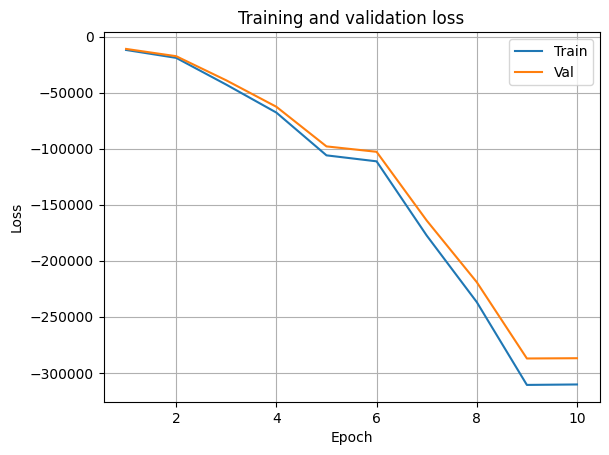

In [5]:
ite = np.array(list(range(epoch))) + 1
plt.plot(ite, training_loss, ite, validation_loss)
plt.grid(True, which="both")
plt.title('Training and validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Val'])
plt.show()

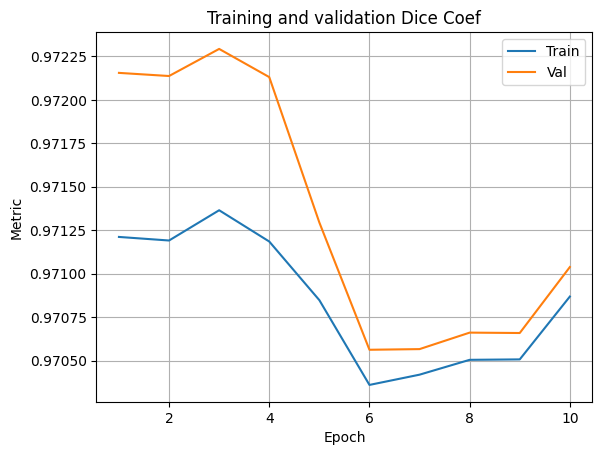

In [7]:
plt.grid(True, which="both")
plt.plot(ite, training_metric, ite, validation_metric)
plt.title('Training and validation Dice Coef')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend(['Train', 'Val'])
plt.show()

In [17]:
best_epoch = np.argmax(validation_metric)
print('Best epoch is', best_epoch+1, 'and dice coefficient of test set at this epoch is', testing_metric[best_epoch])

Best epoch is 3 and dice coefficient of test set at this epoch is 0.9722925007343293
